# "You Snooze, You Win" Challenge
> Medlytics Week 2 Challenge Project

Every year, the [PhysioNet/Computing in Cardiology (CinC) Challenge](https://www.physionet.org/challenge/) invites "participants to **tackle clinically interesting problems** that are either **unsolved or not well-solved**." For the week 2 challenge project, BWSI Medlytics has revived a past PhysioNet challenge based on sleep classification.

This challenge focuses on the classification of nonarousal and arousal time frames. If you would like to understand the biological implications of this project, we recommend reading PhysioNet's [introduction](https://physionet.org/content/challenge-2018/1.0.0/) of the challenge.

For this challenge, you will classify samples into **5 classes** (Arousal, NREM1, NREM2, NREM3, REM). Each sample consists of 7 physiological signals (O2-M1, E1-M2, Chin1-Chin2, ABD, CHEST, AIRFLOW, ECG) measured at 200 Hz over a 60 second period (12,000 timepoints). In this notebook, we provide code to import the data, visualize sample signals, implement an example classifier, and "score" your model.

In [1]:
### Import libraries

import matplotlib.pyplot as plt
import matplotlib

# Set default plotting fonts
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

import numpy as np
import os
import pandas as pd
import random
from sklearn import metrics
from sklearn.utils import shuffle
import tensorflow as tf
import pickle

## Loading the Dataset

This dataset is a modified version of the PhysioNet/CinC Challenge data, which were contributed by the Massachusetts General Hospital's Computational Clinical Neurophysiology Laboratory and the Clinical Data Animation Laboratory.

**Class labels:**

- 0 = Arousal
- 1 = NREM1
- 2 = NREM2
- 3 = NREM3
- 4 = REM

**Class descriptions:**

![sleepStagesTable.svg](https://raw.githubusercontent.com/MedlyticsUniversal/Data/main/Images/sleepStagesTable.svg)

**Physiological signal descriptions:**

**O2-M1** - posterior brain activity (electroencephalography)

**E1-M2** - left eye activity (electrooculography)

**Chin1-Chin2** - chin movement (electromyography)

**ABD** - abdominal movement (electromyography)

**CHEST** - chest movement (electromyography)

**AIRFLOW** - respiratory airflow

**ECG** - cardiac activity (electrocardiography)

## Loading Data in Memory
Run the cell below to extract the raw training and test data. It may take a minute or two to run through. Here are the variables containing the data you will get:

* **data_train**: numpy array shape (4000, 12000, 7). Contains 4,000 samples (60 sec each) of 12,000 data points (200 Hz x 60s), for 7 different signals. 
* **labels_train**: numpy array shape (4000,). Contains ground truth labels for `data_train`. The order of the labels corresponds to the order of the training data.
* **ID_train**: list of 4,000 unique IDs. The order of the IDs corresponds to the order of the training data. 
* **data_test**: numpy array shape (1000, 12000, 7). Contains 1,000 samples (60s each) of 12,000 data points (200 Hz x 60s), for 7 different signals.
* **ID_test**: list of 1,000 unique IDs. The order of the IDs corresponds to the order of the testing data.

We encourage you to print each of these variables to see what they look like.

In [ ]:
### Functions to import data

proj_dir = 'https://raw.githubusercontent.com/MedlyticsUniversal/Data/main/Week2/ChallengeProject/'

def get_sample_data(data_type, id_number):
    '''
    Get signal data, label, and filename associated with given data type and index num

    parameters:

        data_type -- Dictates whether sample comes from training set or test set.
                    This input must be either 'training' or 'test' (defaults to 'training')

        id_number -- Which sample ID should be returned? Must be 0-3999 if data_type is 'training'
                    or 0-999 if data_type is 'test' (defaults to random integer from 0-999)
  
    returns:

        sample_data -- DataFrame with 1 row and 2 columns-- column "Signal" contains a series object 
                    and column "Label" contains numeric label for that sample
    '''
    file_name = data_type + '/' + str(id_number) + '.xz'

    # Sample_data is a DataFrame with 1 row and 2 columns:
    # 1) "Signal" (contains a series object) and 2) "Label" (contains numeric label)
    sample_data = pd.read_pickle(proj_dir + file_name)

    return sample_data, file_name.split('/')[1]

In [ ]:
data_train = np.zeros((4000, 12000, 7))
labels_train = np.zeros(4000)
ID_train = []
for i in range(4000):
    sample_data, ID = get_sample_data('training', i)
    data_train[i] = np.array(list(sample_data['Signal']), dtype=np.float64).reshape(12000, 7)
    labels_train[i] = np.array(list(sample_data['Label']), dtype=np.float64)
    ID_train.append(ID)
    if(i%500==0):
        print('Loading training sample ' + str(i))
print(f"{len(ID_train)} training samples uploaded")

Loading training sample 0
Loading training sample 500
Loading training sample 1000
Loading training sample 1500
Loading training sample 2000
Loading training sample 2500
Loading training sample 3000
Loading training sample 3500
4000 training samples uploaded


In [3]:
data_test = np.zeros((1000, 12000, 7))
ID_test = []
for i in range(1000):
    sample_data, ID = get_sample_data('test', i)
    data_test[i] = np.array(list(sample_data['Signal']), dtype=np.float64).reshape(12000, 7)
    ID_test.append(ID)
    if(i%500==0):
        print('Loading test sample ' + str(i))
print(f"{len(ID_test)} test samples found")

NameError: name 'np' is not defined

## Data Visualization

Run the cell below to visualize the raw data for a single 60-second sample of all 7 signals. We strongly urge you to visualize a few different samples to get a feel for how the data looks and how much each signal can vary in amplitude and frequency between samples. You can change which sample is being visualized by changing the arguments to the `graph_signals` call.

In [1]:
### Define some useful functions to retrieve and plot data from individual samples

""" Initalize key reference dictionaries """
sig_dict = {0:'O2-M1', 1:'E1-M2', 2:'Chin1-Chin2', 3:'ABD', 4:'CHEST', 5:'AIRFLOW', 6:'ECG'}
sig_type_dict = {0:'Time (s)', 1:'Frequency (Hz)'}
stage_dict = {0:'Arousal', 1:'NREM1', 2:'NREM2', 3:'NREM3', 4:'REM'}

def graph_signals(data_type = 'training', id_number = None):
    '''
    Create a graph of multiple signals where rows represent signal class and
    columns represent signal domain (i.e. time or frequency) 
    
    inputs:
    
      parameters:

      data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

      id_number -- Which sample ID should be returned? Must be 0-3999 if data_type is 'training'
                 or 0-999 if data_type is 'test' (defaults to random integer from 0-999)
  
    '''

    assert data_type in ['test','training'], 'data_type should be either "test" or "training"'

    if id_number is None:
      if data_type == 'training':
        id_number = random.randint(0,3999)
      else:
        id_number = random.randint(0,999)

    # Get signal values in time domain
    # Set time_signal_y based on 'test' or 'training' input
    if data_type == 'training':
        time_signal_y = data_train[id_number,:,:]
    else:
        time_signal_y = data_test[id_number,:,:]

    # This time axis doesn't change
    time_signal_x = np.arange(0, 60, step = 1/200)

    # Use time domain signals to get frequency domain signals
    num_datapoints = time_signal_x.shape[0]
    freq_signal_x = np.arange(num_datapoints//2 + 1)/60
    freq_signal_y = np.ndarray(shape = (num_datapoints//2 + 1, 7))
    freq_signal_y = np.abs(np.fft.rfft(time_signal_y, axis = 0))

    plt.figure(figsize = (20, 18))
    title_list = ['Time Domain', 'Freq Domain']
    # 7 classes of signal (O2-M1, E2-M2, etc.)
    for signal_index in range(7):
        # 2 types of signal (time and freq domain)
        for signal_domain_index in range(2):
            plt.subplot(7, 2, 2*signal_index + signal_domain_index + 1)
            if signal_index==0:
                plt.title(title_list[signal_domain_index])
            if signal_domain_index == 0: # Plot time domain signal
                plt.plot(time_signal_x, time_signal_y[:,signal_index])
            if signal_domain_index == 1: # Plot freq domain signal
                plt.plot(freq_signal_x, freq_signal_y[:,signal_index])
            plt.ylabel(sig_dict[signal_index])
        plt.xlabel(sig_type_dict[signal_domain_index])
    plt.show()

# Use the above functions to retrieve data for a single sample (in the test or training set) and plot it

# Change these 2 lines to plot different samples (note that the test set only has 1000 samples)
data_type = 'training' # <--- try 'test' too
id_number = random.randint(0, 3999) # <--- try picking a specific value here

# Print signal ID and the sample label (if known)
if data_type == 'training': 
    print(data_type.title(), 'Sample #' + str(id_number), '(' + stage_dict[id_number//800] + ')')
else: 
    print(data_type.title(), 'Sample #' + str(id_number), '(To Be Predicted)')

# Plot data from this sample
graph_signals(data_type = data_type, id_number = id_number)

NameError: name 'random' is not defined

In [2]:
labels_train

NameError: name 'labels_train' is not defined

## Example Classifier

Below is an example of a mediocre classifier for this dataset. It is a simple neural network that uses the spectral flatness of all signal types as its input features—that is, it has 7 input features.

While the example classifier makes use of a neural network, you can utilize any ML algorithm that you feel would be appropriate.

In [ ]:
### Define functions that calculate the features of a single sample

import scipy.stats.mstats as mstats

# We're going to use spectral_flatness of the fft as a feature that can be used

def spectral_flatness(fft, zero_thresh = None): 
  N = len(fft) 
  magnitude = abs(fft[:N//2])* 2 / N 

  if(zero_thresh is not None):
      magnitude[magnitude < zero_thresh] = zero_thresh

  if(any(magnitude<zero_thresh)):
    raise ValueError("This shouldn't happen")

  sf = mstats.gmean(magnitude) / np.mean(magnitude) 
  
  return sf

def get_features_for_single_sample(data_type = 'training', id_number = None):
    '''
    Calculate feature values for a single sample

    parameters:

      data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

      id_number -- Which sample ID should be returned? Must be 0-3999 if data_type is 'training'
                 or 0-999 if data_type is 'test' (defaults to random integer from 0-999)
  
    returns:

      feature_vector -- 1D array containing all feature values for this sample
    '''

    assert data_type in ['test','training'], 'data_type should be either "test" or "training"'

    if id_number is None:
        id_number=random.randint(0,999)

    if data_type == 'training':
        time_signal_y = data_train[id_number,:,:]
    else:
        time_signal_y = data_test[id_number,:,:]
  
    #---Populate feature vector ---
    # Example uses spectral flatness, but you can populate feature_vector with anything that seems useful

    # Get an fft for all signals in this sample
    fft_arr = np.fft.rfft(time_signal_y, axis = 0)
    
    # Initialize feature vector to zeros of right size
    feature_vector = np.zeros((time_signal_y.shape[1],1))

    # Enumerate over all classes of signal, calculate spectral flatness for each, and append value to feature_vector
    for ind in range(fft_arr.shape[1]): # For every class of signal
        # Calculate spectral flatness and add it to a feature vector
        feature_vector[ind] = spectral_flatness(fft_arr[:,ind], zero_thresh = 10**-10)

    #---Finished populating feature vector---
    # (feature_vector is now populated with hand-engineered features for this sample)

    return feature_vector
    
def get_features(data_type, num_samples):
    '''
    Retrieve features from num_samples samples in either test or training set
    Return features for each sample and index of each sample
    
    inputs:
    
      data_type -- Dictates whether sample comes from training set or test set.
                 This input must be either 'training' or 'test' (defaults to 'training')

      num_samples -- For how many samples should features be calculated?
                  (should not exceed total samples in a given data_type)
  
    returns:

      features -- n x p array of feature values for all samples where rows 
                  correspond to samples and columns correspond to feature number

      order -- 1D array where index i contains the index of row i of the feature vector
               (only needed if shuffling takes place later)
    '''

    features, order = np.array([]), np.array([])
    for i in range(num_samples):
        single_sample_features = get_features_for_single_sample(data_type = data_type, id_number = i)
        features = np.hstack((features, single_sample_features)) if features.size else single_sample_features
        order = np.append(order, i).astype(np.float32)

    # Ensure features are of type float32    
    features = features.astype(np.float32)

    return np.transpose(features), order


In [ ]:
### Run every time you modify your feature extraction

print('Calculating features for training data...')
train_data, train_order = get_features('training', 4000)

print('Calculating features for test data...')
test_data, test_order = get_features('test', 1000)

Calculating features for training data...
Calculating features for test data...


NameError: name 'data_test' is not defined

## Visualize Entire Dataset's Features

In [ ]:
### Create label array for all training samples using categorical data type

train_labels = np.ndarray(shape = (1, 4000))

# Set labels to integers first
for i in range(4000):
    train_labels[0][i] = i//800 # This is a way to label each entry (since classes are in order)

# Convert labels to onehot and ensure type is float32
train_labels = tf.keras.utils.to_categorical(train_labels[0], 5)
train_labels = train_labels.astype(np.float32)

train_data.shape = (4000, 7)
train_labels.shape = (4000, 5)

train data:
 [[0.5374547  0.65097207 0.6926247  ... 0.1091985  0.1252919  0.5075645 ]
 [0.4168214  0.47627234 0.7702475  ... 0.09220966 0.39203906 0.5782002 ]
 [0.4703415  0.46828052 0.6595881  ... 0.13999489 0.27351436 0.47463748]
 ...
 [0.4387015  0.37351102 0.6888008  ... 0.17966141 0.2708532  0.5644236 ]
 [0.3960266  0.2516653  0.68518984 ... 0.05493095 0.29760432 0.53879225]
 [0.42380518 0.2671166  0.7641057  ... 0.21202092 0.34283185 0.47600362]]

train labels:
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


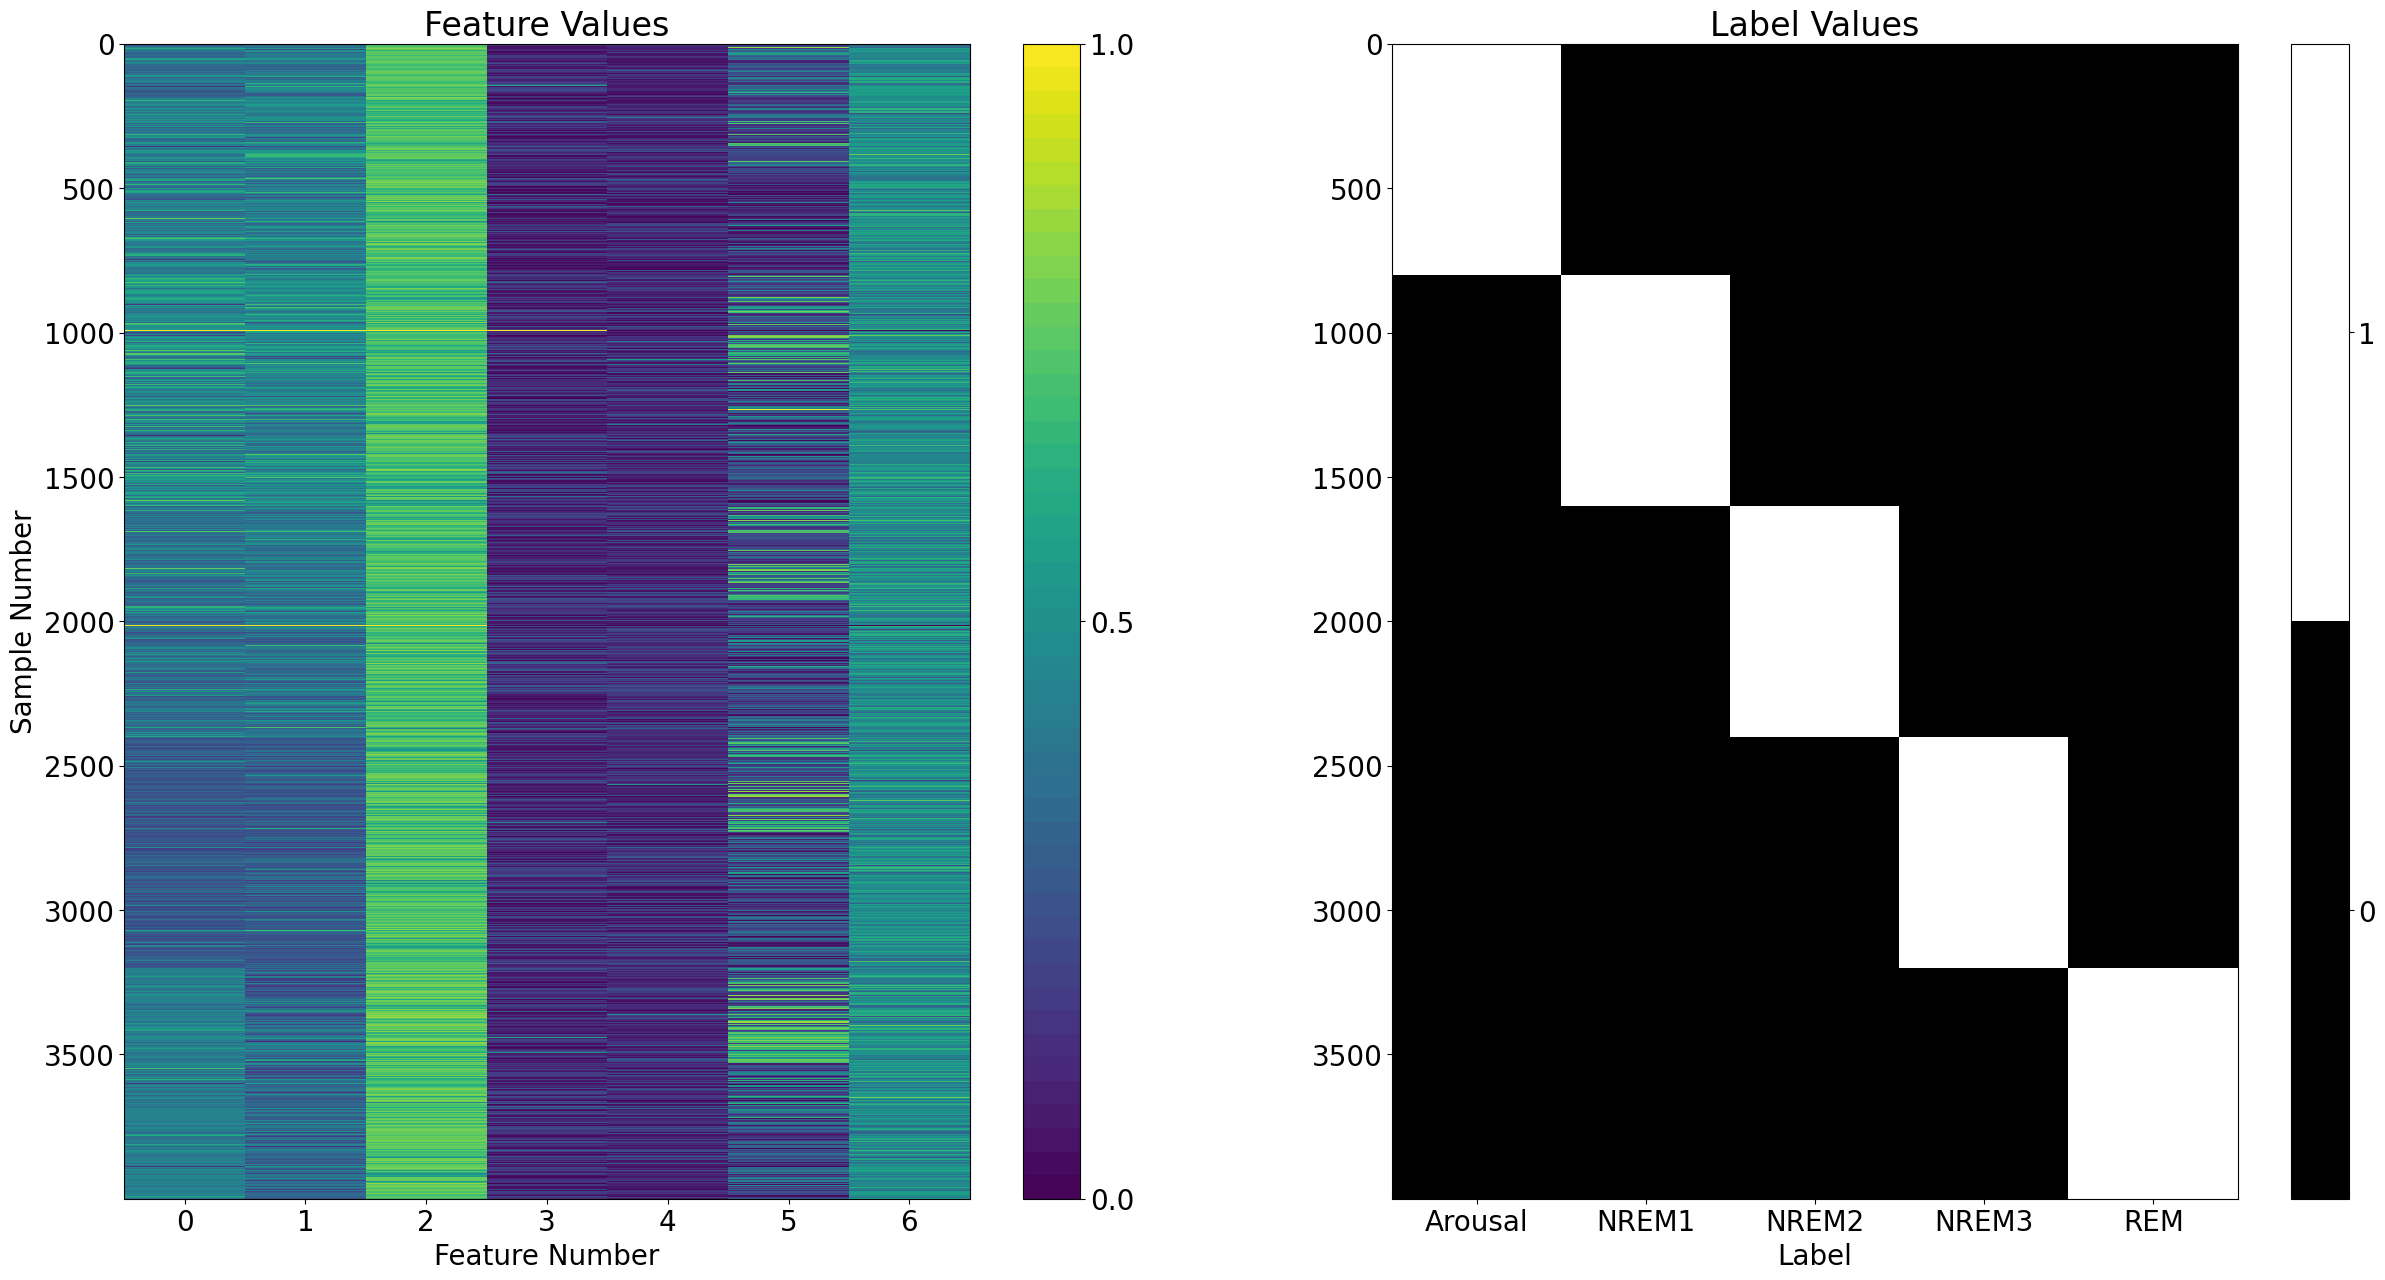

In [ ]:
### Run whenever you want to check or view your data and labels
print(f"train_data.shape = {train_data.shape}")
print(f"train_labels.shape = {train_labels.shape}\n")
print(f"train data:\n {train_data}\n\ntrain labels:\n {train_labels}")

# Plot feature values and label values to show data clearly
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize= (30,15))

# Note: if your features are not scaled to the range (0-1), you might want to change vmin and vmax
featureImg = ax1.imshow(train_data[:,:], aspect = 'auto', interpolation = 'None') # vmin = 0, vmax = 1.0
ax1.set_title('Feature Values')
ax1.set_ylabel('Sample Number')
ax1.set_xlabel('Feature Number')
fig.colorbar(featureImg, ax = ax1, boundaries = np.linspace(0.0, 1.0, 50), ticks = [0,0.5,1])

from matplotlib.colors import ListedColormap
bw_cmap = ListedColormap(np.array([[0,0,0,1],[1,1,1,1]])) # Make a colormap manually
labelImg = ax2.imshow(train_labels, aspect = 'auto', cmap = bw_cmap,interpolation = 'None', vmin = 0, vmax = 1.0)
ax2.set_title('Label Values')
ax2.set_xlabel('Label')
ax2.set_xticks(range(len(stage_dict)))
ax2.set_xticklabels([stage_dict[i] for i in range(len(stage_dict))])
fig.colorbar(labelImg, ax = ax2, boundaries = np.linspace(-0.5, 1.5,3), ticks = [0, 1])

In [ ]:
#### Run every time you modify your feature extraction

# This cell splits up the labeled data into 3 subsets (training, validation, and test data)

# This 3-way split is very common in training a supervised learning model. The purpose of
# each partition is as follows:

# 1) Training data is used to adjust model weights (so-called model parameters)
# 2) Validation data is used to gauge how well a model generalizes (allowing users
#    to compare between different trained models and/or non-trained model 
#    parameters (hyperparameters))
# 3) Test data is used to provide an indicator of real world performance (it 
#    should not be used when deciding between models because this would result 
#    in overfitting!)

train_data_shuffled, train_labels_shuffled = shuffle(train_data, train_labels, random_state = 25)

""" val_size (int) must be from 0-4000 """
val_size = 1000
mocktest_size = 500

val_data = train_data_shuffled[:val_size]
mocktest_data = train_data_shuffled[val_size:val_size + mocktest_size]
partial_train_data = train_data_shuffled[val_size + mocktest_size:]

val_labels = train_labels_shuffled[:val_size]
mocktest_labels = train_labels_shuffled[val_size:val_size + mocktest_size]
partial_train_labels = train_labels_shuffled[val_size + mocktest_size:]

training_set = tf.data.Dataset.from_tensor_slices((partial_train_data, partial_train_labels))
training_set = training_set.batch(40) #set batch size

2023-10-17 18:05:19.578643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-17 18:05:19.578715: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-17 18:05:19.578748: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-4bd269d2-1ec8-4eae-9d67-f9ba1d62e2c9): /proc/driver/nvidia/version does not exist
2023-10-17 18:05:19.579348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
### Run every time you change set of parameters

model = tf.keras.Sequential()

""" Modify to your heart's and algorithm's content ^_^ """

model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)))
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
# We should end with a softmax to ensure outputs behave like probabilities (i.e. sum to 1)
model.add(tf.keras.layers.Dense(5, activation=tf.nn.softmax)) 

opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
# Another potential optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4,997
Trainable params: 4,997
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### Run whenever you want to train and validate your model

"""
EPOCHS (int): the number of times the optimization algorithm passes
through the full dataset (calculating errors and derivatives) to update weights
(One pass through the data is called an "epoch")
"""

EPOCHS = 50

for epoch in range(EPOCHS):
    for signals, labels in training_set:
        tr_loss, tr_accuracy = model.train_on_batch(signals, labels)
    val_loss, val_accuracy = model.evaluate(val_data, val_labels)
    print(('Epoch #%d\t Training Loss: %.2f\tTraining Accuracy: %.2f\t'
         'Validation Loss: %.2f\tValidation Accuracy: %.2f')
         % (epoch + 1, tr_loss, tr_accuracy,
         val_loss, val_accuracy))

2023-10-17 18:05:42.259993: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-10-17 18:05:42.267018: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-10-17 18:05:42.556553: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-10-17 18:05:42.570174: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
32/32 [==============================] - 0s 3ms/step - loss: 1.6135 - accuracy: 0.1750
Epoch #1	 Training Loss: 1.62	Training Accuracy: 0.15	Validation Loss: 1.61	Validation Accuracy: 0.17
2023-10-17 18:05:43.356012: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-10-17 18:05:43.379728: W tensorflow/core/data/root_dataset.cc:266] Optimization loop failed: CANCELLED: Operation was cancelled
2023-10-17 18

In [ ]:
### Run once after you have finished training your model

test_pred = model.predict(test_data)
test_output = np.ndarray(shape = (1000, 6))

""" Add column with file number """
for i in range(1000):
    test_output[i] = np.append(test_pred[i], test_order[i]) 
test_dataframe = pd.DataFrame(test_output)

""" Sort DataFrame according to file number """
sorted_test_dataframe = test_dataframe.sort_values(by=[5])

""" Drop file number column """
processed_test_dataframe = sorted_test_dataframe.drop(sorted_test_dataframe.columns[5], axis=1)

print(test_dataframe.head(), '\n\n', sorted_test_dataframe.head(), '\n\n', processed_test_dataframe.head())

# In the file name, make sure to indicate your team number.
# The file should show up in the file explorer to the left under Week2 > ChallengeProject
# Download the pickle file and evaluate it on the Medlytics app
file_name = 'team#_week2_test_preds.pkl'
processed_test_dataframe.to_pickle(file_name)

test_dataframe = pd.DataFrame(test_output)
os.listdir('.')

32/32 [==============================] - 0s 1ms/step
          0         1         2         3         4    5
0  0.109777  0.115175  0.170210  0.365535  0.239303  0.0
1  0.261580  0.294806  0.193466  0.087531  0.162618  1.0
2  0.218541  0.214778  0.206553  0.164659  0.195470  2.0
3  0.190531  0.147441  0.190176  0.252369  0.219484  3.0
4  0.242318  0.214504  0.204364  0.151258  0.187555  4.0 

           0         1         2         3         4    5
0  0.109777  0.115175  0.170210  0.365535  0.239303  0.0
1  0.261580  0.294806  0.193466  0.087531  0.162618  1.0
2  0.218541  0.214778  0.206553  0.164659  0.195470  2.0
3  0.190531  0.147441  0.190176  0.252369  0.219484  3.0
4  0.242318  0.214504  0.204364  0.151258  0.187555  4.0 

           0         1         2         3         4
0  0.109777  0.115175  0.170210  0.365535  0.239303
1  0.261580  0.294806  0.193466  0.087531  0.162618
2  0.218541  0.214778  0.206553  0.164659  0.195470
3  0.190531  0.147441  0.190176  0.252369  0.2194

['.git',
 'Data',
 'README.md',
 'Week2_ChallengeProject.pptx',
 'team#_week2_test_preds.pkl']

## Submitting Your Model

After training your classifier, run it on the **test data** to generate your predictions. Each class for a test sample should have an associated probability (between 0 and 1). Below are the parameters for the prediction format and export:

- Your predictions should be in a Pandas DataFrame with **5 columns** (classes) and **1,000 rows** (samples). Note that your predictions must follow the original test sample order (`0.xz`, `1.xz`, `2.xz`, ...). You only need to worry about this if you shuffled the test samples or stored the samples in an unordered data structure (dictionaries and sets). If this is the case, you should 1) add a separate column in your DataFrame with the file number for each sample; 2) sort the DataFrame using this column; and 3) drop the column. These steps have been noted in the code below.
- The predictions should be exported as a `.pkl` file using `DataFrame.to_pickle()`. The file should show up in the file explorer to the left under Week2 > Challenge_Project.
- Download the pickle file and assess it on the Medlytics [**Evaluator App**](https://medlytics-evaluator.streamlit.app/Week_2).

Example code of the prediction format and export is presented in the cell block above. 

Your model will be evaluated on Area Under the ROC Curve (AUROC), Matthews Correlation Coefficient (MCC), and creativity.

If you are finished early, consider trying other ML algorithms and/or implementing multiple feature extraction methods. You can also help other groups if you finish early.

## How Your Model Will Be Evaluated

1. **Area Under the ROC Curve (AUROC)**: The receiver operating characteristic (ROC) curve plots the true positive rate (sensitivity/recall) against the false positive rate (fall-out) at many decision threshold settings. The area under the curve (AUC) measures the classifier's ability to correctly identify samples from the "positive" and "negative" cases. Intuitively, AUC is the probability that a randomly chosen "positive" sample will be labeled as "more positive" than a randomly chosen "negative" sample. In the case of a multiclass ROC curve, each class is considered separately before taking the weighted average of all the class results. Simply put, the class under consideration is labeled as "positive" while all other classes are labeled as "negative." The AUROC should be between 0 and 1, in which 0.5 is random classification and 1 is perfect classification.

2. **Matthews Correlation Coefficient (MCC)**: The MCC measures the quality of binary classifications, irrespective of the class sizes. Importantly, it is typically regarded as a balanced measure since it considers all values in the 2x2 contingency table (TP, FP, TN, FN). For this challenge, the binary classes will be "Arousal" (Arousal) and "Nonarousal" (NREM1, NREM2, NREM3, REM). The MCC score should be between -1 and 1, in which 0 is random classification and 1 is perfect classification.

![mcc_calc.svg](https://raw.githubusercontent.com/MedlyticsUniversal/Data/main/Images/mcc_calc.svg)

3. **Creativity**: ( ͡° ͜ʖ ͡°)

Below is the code used to calculate the AUROC and MCC metrics when evaluating your classifier.

In [ ]:
test_pred = pd.DataFrame(model.predict(mocktest_data))
test_predict = test_pred.idxmax(axis=1)
test_labels = [ np.where(label==1)[0][0] for label in mocktest_labels]
test_labels_one_hot = pd.DataFrame(mocktest_labels)

16/16 [==============================] - 0s 920us/step


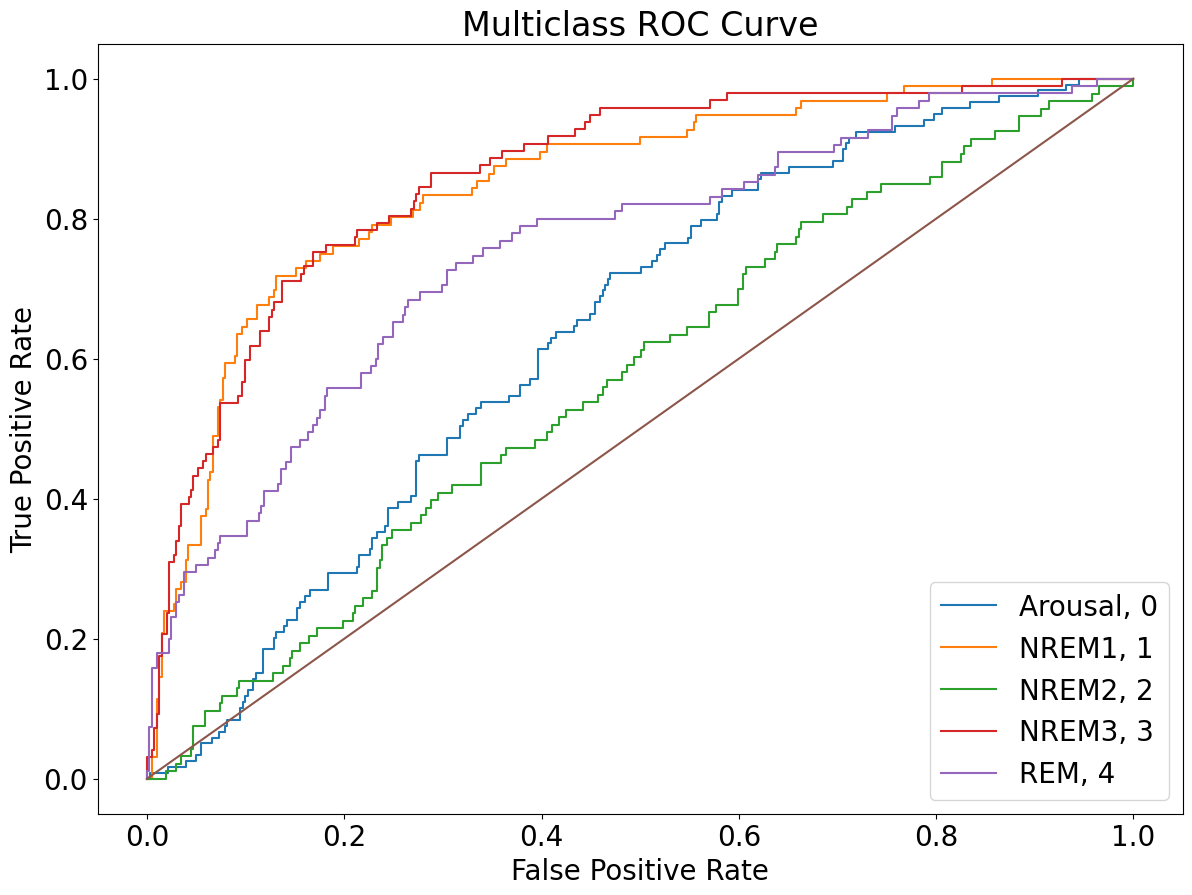

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(14,10))
for i in range(5):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_labels_one_hot.iloc[:, i], test_pred.iloc[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label = stage_dict[i] + ', ' + str(i))

plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend()
plt.show()

fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_labels_one_hot.values.ravel(), test_pred.values.ravel())
roc_auc_agg = metrics.auc(fpr["micro"], tpr["micro"])

In [ ]:
y_true = []
y_pred = []
for i in range(test_pred.shape[0]):
    if test_predict.iloc[i]==0: y_pred.append(1)
    else: y_pred.append(-1)
    if test_labels[i]==0: y_true.append(1)
    else: y_true.append(-1)
mcc = metrics.matthews_corrcoef(y_true, y_pred)

In [ ]:
print("Multiclass AUROC:", roc_auc_agg)
print("Matthews Correlation Coefficient:", mcc)

Multiclass AUROC: 0.7521129999999999
Matthews Correlation Coefficient: 0.19799870858507634


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=33044a74-d70f-4ea2-b5ea-7edb4661583d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>